
# **Foundations of Deep Learning: Final Project**


# Installing & Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.8 MB/s eta 0:00:00


In [ ]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2
from shutil import copyfile as cf
import glob
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm

In [ ]:
import albumentations as A

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout
from keras.utils import to_categorical
import segmentation_models as sm


Segmentation Models: using `keras` framework.


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14665170339399548296
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3784751493073302531
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tarfile

# Model Logs Settings

In [ ]:
MODEL_TYPE = "DSBA FDL Final Project - PSPNet Model - Final Submission"
EPOCHS = 100
LR = 0.0001 #Initial LR - Decays exponentially
EXP_DEC = True
DATE = "24_Jan"
WIDTH = 480 #Resized Image dims
HEIGHT = 480
RESIZE = (WIDTH,HEIGHT)
ATTEMPT_NO = 1
BATCH_SIZE = 4
BACKBONE = 'vgg19'

In [ ]:
MODEL_NAME = MODEL_TYPE + "_" + DATE + "_" + str(ATTEMPT_NO)

In [ ]:
CLASSES = {
                "Unlabelled" : 0,
                "Property Roof": 1,
                "Secondary Structure": 2,
                "Swimming Pool": 3,
                "Vehicle": 4,
                "Grass": 5,
                "Trees / Shrubs": 6,
                "Solar Panels": 7,
                "Chimney": 8,
                "Street Light": 9,
                "Window": 10,
                "Satellite Antenna": 11,
                "Garbage Bins": 12,
                "Trampoline": 13,
                "Road / Highway": 14,
                "Under Construction / In Progress Status": 15,
                "Power Lines & Cables": 16,
                "Bridge": 17,
                "Water Tank / Oil Tank": 18,
                "Parking Area - Commercial": 19,
                "Sports Complex / Arena": 20,
                "Industrial Site": 21,
                "Dense Vegetation / Forest": 22,
                "Water Body": 23,
                "Flooded": 24,
                "Boat": 25,
                "Parking Area" : 26
          }

In [ ]:
label_names = list(CLASSES.keys())
NUM_CLASSES = len(label_names)

# Data Directory Creation

In [ ]:
Root_Directory = os.getcwd()
root_dir = Root_Directory
print(Root_Directory)


/content


Augmented images are already placed on the drive

In [ ]:
raw_root = "/content/drive/MyDrive/DL_Data/Hurricane_Harvey/rasters/raw" 
mask_root = "/content/drive/MyDrive/DL_Data/Hurricane_Harvey/vectors/random-split-_2022_11_17-22_35_45/Masks" 
raw_out = "/content/drive/MyDrive/DL_Data/Aug_Data2/Images/"
mask_out = "/content/drive/MyDrive/DL_Data/Aug_Data2/Masks/"

Train_Images = root_dir + "/Train/Images/"
Validation_Images = root_dir + "/Validation/Images/"
Test_Images = root_dir + "/Test/Images/"

Train_Masks = root_dir + "/Train/Masks/"
Validation_Masks = root_dir + "/Validation/Masks/"
Test_Masks = root_dir + "/Test/Masks/"

Models_dir = "/content/drive/MyDrive/DL_Data/NEW/Models/" 

In [ ]:
os.makedirs(Models_dir , exist_ok=True)
os.makedirs(Train_Images , exist_ok=True)
os.makedirs(Validation_Images , exist_ok=True)
os.makedirs(Test_Images , exist_ok=True)
os.makedirs(Train_Masks , exist_ok=True)
os.makedirs(Validation_Masks , exist_ok=True)
os.makedirs(Test_Masks , exist_ok=True)


In [ ]:
rasters_name = []
masks_name = []

for img in glob.glob(raw_root + "/*"):
    rasters_name.append(img.split('/')[-1].split('.')[0])

for img in glob.glob(mask_root + "/*"):
    masks_name.append(img.split('/')[-1].split('.')[0])

In [ ]:
Test_names = []
for i in rasters_name:
    if i not in masks_name:
        Test_names.append(i)

In [ ]:
rasters_dir = []
masks_dir = []

for img in glob.glob(raw_out + "*"):
    rasters_dir.append(img)

for img in glob.glob(mask_out + "*"):
    masks_dir.append(img)

In [ ]:
Train_Image_dirs, Validation_Image_dirs = train_test_split(rasters_dir , test_size = 0.1, random_state = 9)

In [ ]:
Train_Masks_dirs = [dir.replace("Images","Masks").replace(".tif",".png") for dir in Train_Image_dirs]
Validation_Masks_dirs = [dir.replace("Images","Masks").replace(".tif",".png") for dir in Validation_Image_dirs]

In [ ]:
print( " Train Size: ", len(Train_Masks_dirs) )
print( " Validation Size: ", len(Validation_Masks_dirs) )

 Train Size:  269
 Validation Size:  30


In [ ]:
for dir in tqdm(Train_Image_dirs):
    cf(dir, Train_Images + "/" + dir.split("/")[-1])
    cf(dir.replace("Images","Masks").replace(".tif",".png"), Train_Masks + "/" + dir.split("/")[-1].split(".")[0] + ".png")

100%|██████████| 269/269 [01:02<00:00,  4.28it/s]


In [ ]:
for dir in tqdm(Validation_Image_dirs):
    cf(dir, Validation_Images + "/" + dir.split("/")[-1])
    cf(dir.replace("Images","Masks").replace(".tif",".png"), Validation_Masks + "/" + dir.split("/")[-1].split(".")[0] + ".png")

100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


In [ ]:
count = 0
for dir in tqdm(glob.glob(raw_root+"/*")):
    if dir.split("/")[-1].split(".")[0] in Test_names:
        cf(raw_root + "/" + dir.split("/")[-1], Test_Images + dir.split("/")[-1])
        count = count + 1
print("Test Images Count : " + str(count))

100%|██████████| 374/374 [00:04<00:00, 80.59it/s] 

Test Images Count : 75


# DataGenerators Setup

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):

    def __init__(self, image_path, mask_path,
                 to_fit=True, batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH),
                 n_channels=3, n_classes=NUM_CLASSES, shuffle=True):

        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """

        self.list_IDs = [ int(i) for i in range(len(os.listdir(image_path))) ]
        self.labels = [ i.split("/")[-1].split(".")[0] for i in os.listdir(image_path) ]
        self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_image(self.image_path + self.labels[ID] + ".tif")

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_mask(self.mask_path + self.labels[ID] + ".png")

        return y

    def _load_image(self, image_path):
        """Load RBG image to array
        :param image_path: path to image to load
        :return: loaded image
        """
        img = cv2.imread(image_path,1)
        img = img / 255
        img = np.array(img)
        return img
    
    def _load_mask(self, mask_path):
        """Load mask image and encode
        :param image_path: path to mask to load
        :return: loaded image with one hot encode
        """
        img = cv2.imread(mask_path)
        img = np.array(img)
        img = np.sum(img, axis = 2)/3
        img = img[..., np.newaxis]
        img = to_categorical(img, num_classes=self.n_classes)
        return img


In [ ]:
train_data = DataGenerator(Train_Images,Train_Masks)
validation_data = DataGenerator(Validation_Images,Validation_Masks)

In [ ]:
# check shapes for errors
assert train_data[0][0].shape == (BATCH_SIZE, HEIGHT, WIDTH, 3)
assert train_data[0][1].shape == (BATCH_SIZE, HEIGHT, WIDTH, NUM_CLASSES)

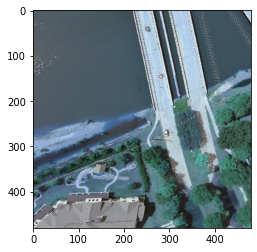

In [ ]:
plt.imshow(np.array(train_data[0][0][2]*255, dtype=int))

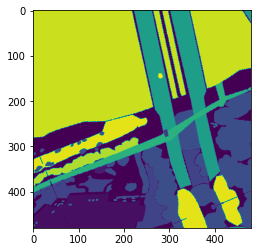

In [ ]:
plt.imshow(np.argmax(train_data[0][1][2], axis = 2)/NUM_CLASSES)

# Model Setup

In [ ]:
num_train_samples = len(Train_Masks_dirs)
num_val_samples = len(Validation_Masks_dirs)
steps_per_epoch = np.ceil(float(num_train_samples) / float(BATCH_SIZE))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(BATCH_SIZE))
print('validation_steps: ', validation_steps)

steps_per_epoch:  68.0
validation_steps:  30.0


In [ ]:
K.clear_session()

In [ ]:
def dice_coef(y_true, y_pred):
    return -1 * (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
model = sm.PSPNet(BACKBONE, encoder_weights='imagenet', classes=NUM_CLASSES, activation='softmax', input_shape = (HEIGHT,WIDTH,3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 480, 480, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 480, 480, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(LR, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(Models_dir , MODEL_NAME + '.h5'),
    save_best_only = False, 
#     save_weights_only = False,
    monitor = 'val_dice_coef', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_dice_coef', 
    min_delta = 0.001, 
    patience = 10, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= Models_dir + MODEL_NAME + ".csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

# Running the Model

In [ ]:
history = model.fit(train_data, 
    steps_per_epoch=steps_per_epoch,
    validation_data = validation_data, 
    validation_steps = validation_steps, 
    epochs = EPOCHS,
    callbacks=callbacks,
    use_multiprocessing=True,
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 1.6134 - dice_coef: -0.3783 - accuracy: 0.5069
Epoch 1: saving model to /content/drive/MyDrive/DL_Data/NEW/Models/DSBA FDL Final Project - PSPNet Model - Final Run_24_Jan_1.h5
68/68 [==============================] - 210s 3s/step - loss: 1.6134 - dice_coef: -0.3783 - accuracy: 0.5069 - val_loss: 2.6668 - val_dice_coef: -0.3726 - val_accuracy: 0.3893 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 1.1753 - dice_coef: -0.4955 - accuracy: 0.6121
Epoch 2: saving model to /content/drive/MyDrive/DL_Data/NEW/Models/DSBA FDL Final Project - PSPNet Model - Final Run_24_Jan_1.h5
68/68 [==============================] - 222s 3s/step - loss: 1.1753 - dice_coef: -0.4955 - accuracy: 0.6121 - val_loss: 1.0880 - val_dice_coef: -0.5185 - val_accuracy: 0.6

#Plottting the Metrics

In [ ]:
# df_result = pd.read_csv(Models_dir + MODEL_NAME + ".csv")
df_result = pd.DataFrame(history.history)
df_result['dice_coef'] = -1 * df_result['dice_coef'] 
df_result['val_dice_coef'] = -1 * df_result['val_dice_coef'] 
df_result

,epoch,accuracy,dice_coef,loss,val_accuracy,val_dice_coef,val_loss
0,0,0.506871,0.378300,1.613394,0.389313,0.372612,2.666803
1,1,0.612073,0.495486,1.175294,0.628549,0.518504,1.087994
2,2,0.666901,0.548507,1.023306,0.517979,0.478253,1.615537
3,3,0.679358,0.566655,0.981627,0.603303,0.525212,1.308252
4,4,0.700834,0.588942,0.914707,0.639577,0.526845,1.109577
5,5,0.723911,0.616264,0.834095,0.669507,0.610790,1.088375
6,6,0.742090,0.635177,0.781576,0.653646,0.580544,1.041717
7,7,0.745667,0.643120,0.751663,0.676405,0.595594,0.980858
8,8,0.760495,0.663302,0.711510,0.677928,0.590075,1.040102
9,9,0.760858,0.661344,0.711587,0.690897,0.587700,1.011027


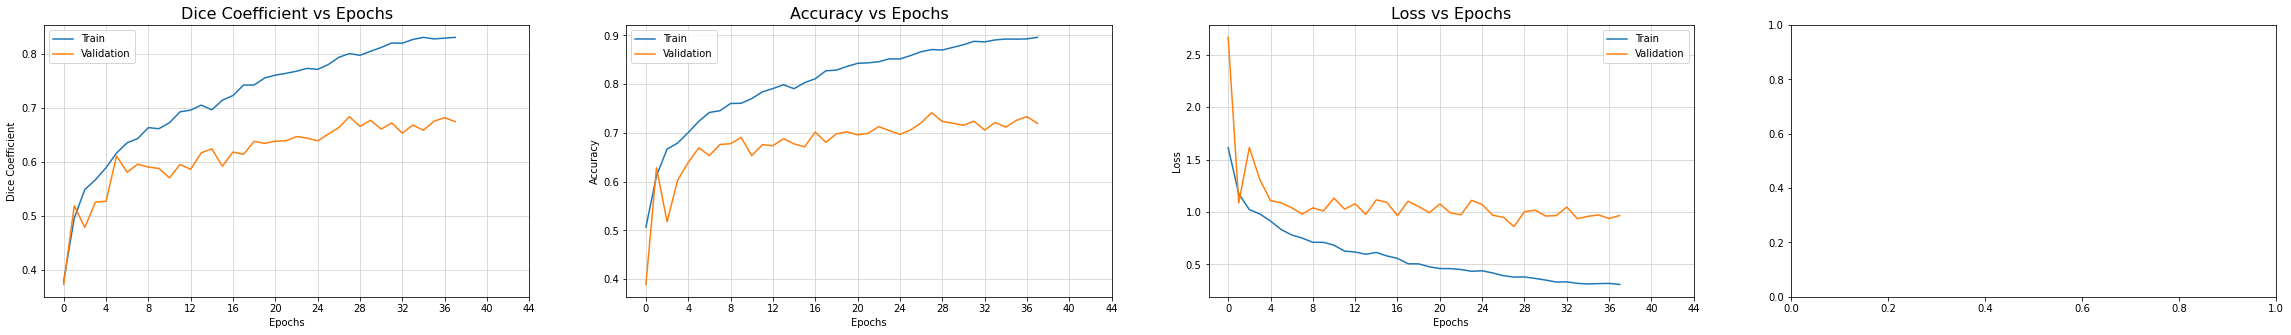

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(df_result[met])
        ax[i].plot(df_result['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(df_result[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

# Prediction on Test Images

### Single tile prediction and resize

In [ ]:
model.load_weights(Models_dir + MODEL_NAME + ".h5")

In [ ]:
#Clearing out previous results
shutil.rmtree(Test_Masks)
os.makedirs(Test_Masks, exist_ok=True)

In [ ]:
images = []
names = []
orig_dims = []

In [ ]:
for name in tqdm(glob.glob(raw_root + "/*")):
    if name.split("/")[-1].split(".")[0] in Test_names:
      img = cv2.imread(name,1)
      orig_dims.append((img.shape[1],img.shape[0]))
      img = cv2.resize(img, RESIZE, interpolation = cv2.INTER_NEAREST)
      img = np.array(img)/255
      names.append(name.split("/")[-1].split(".")[0])
      images.append(img)

100%|██████████| 374/374 [00:15<00:00, 24.78it/s]


In [ ]:
images = np.array(images)
images = tf.convert_to_tensor(images, dtype=float)

In [ ]:
pred = model.predict(images)
pred = np.argmax(pred, axis=3)

3/3 [==============================] - 2s 862ms/step


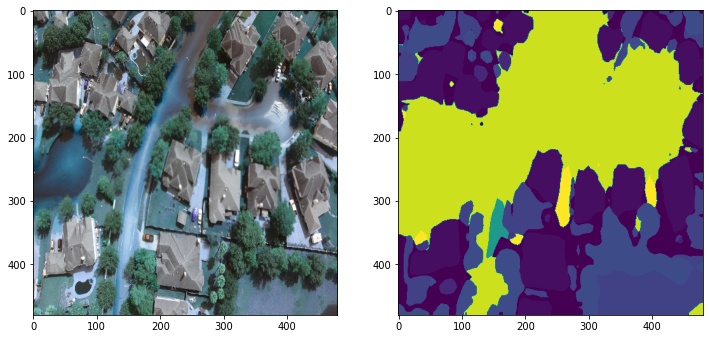

In [ ]:
#Test Sanity Check
image_number = random.randint(0, len(images))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(images[image_number])
plt.subplot(122)
plt.imshow(pred[image_number][:,:])
plt.show()

In [ ]:
for i in range(len(pred)):
    img = cv2.resize(pred[i], orig_dims[i], interpolation = cv2.INTER_NEAREST)
    cv2.imwrite(Test_Masks + names[i] + ".png", img)

# Exporting to Tar

In [ ]:
tar = tarfile.open(Models_dir + MODEL_NAME + ".tar", "w")

for root, dir, files in os.walk(Test_Masks):
    for  file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)

tar.close()